## Univariate Time Series Models from the ARIMA Family Waling Forward
This notebook contains code for setting up and finetune Arima and Sarima models and make forecasts with those models. We do that both for monthly and weekly data, since the changes in the water level variable are often too insignificant for hourly or daily data.

Structure:
1. preparation of necessary packages and functions
2. Analysis of Monthly Data
3. Models for Montly Data
4. ARIMA Model Monthly
5. SARIMA Model Monthly 
6. Analysis of Weekly Data  
7. ARIMA Weekly
8. SARIMA Weekly


Sources:

- Korstanje, J. 2022.  How to Select a Model For Your Time Series Prediction Task. Retrieved from: https://neptune.ai/blog/select-model-for-time-series-prediction-task 

- Graves, A. 2020. Time Series Forecasting with a SARIMA Model. Retrieved from: https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
- https://github.com/mfriebel/waterlevel_prediction
- Jie, T. (2021). An Overview of Time Series Forecasting with ARIMA Models. Retrieved from: https://towardsdatascience.com/time-series-analysis-arima-based-models-541de9c7b4db
- Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2.
- Dettling, M. (2020). Applied Time Series Analysis. Retrieved from: https://ethz.ch/content/dam/ethz/special-interest/math/statistics/sfs/Education/Advanced%20Studies%20in%20Applied%20Statistics/course-material-1921/Zeitreihen/ATSA_Script_v200504.pdf




# 1. Preparation of necessary Packages and Functions

In [1]:
# load necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.model_selection import train_test_split
from datetime import datetime, timedelta


In [2]:
## import and prepare montly data

monthly_data = pd.read_csv("../Data/clean_data/monthly_data.csv")
# convert DateTime column into datetime format
monthly_data["datetime"] = pd.to_datetime(monthly_data['datetime'])
# set DateTime as index
monthly_data.set_index("datetime", inplace=True)
# subset the water_level variable since we are using univariate models
water_monthly = monthly_data[["water_level"]]

## import and prepare weekly data

weekly_data = pd.read_csv("../Data/clean_data/weekly_data.csv")
# convert DateTime column into datetime format
weekly_data["datetime"] = pd.to_datetime(weekly_data['datetime'])
# set DateTime as index
weekly_data.set_index("datetime", inplace=True)
# subset the water_level variable since we are using univariate models
water_weekly = weekly_data[["water_level"]]

In [38]:
# function for calculating different performance measures, namely the MAE, MSE, MAPE and the R-squared

from sklearn.metrics import mean_absolute_error as mae
import numpy as np
from sklearn.metrics import r2_score

def mean_errors(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAE = mae(actual, pred)
    MSE = np.square(np.subtract(actual,pred)).mean()
    MAPE = np.mean(np.abs((actual - pred) / actual)) * 100
    R2_score = r2_score(actual, pred)
    return print("MAE: {:.5f} \nMSE: {:.5f} \nMAPE: {:.5f} \nR2: {:.5f}".format(MAE, MSE, MAPE, R2_score))

In [41]:
# function for Arima model with walking forward validation

def walk_forward_validation_ARIMA(train, test, order):     # takes train and test data as well as the order parameters p,d,q as arguments
    steps=1 # setting the prediction steps to one month
    forecast_series = pd.DataFrame(index=test.index, columns=[x for x in range(steps)]) #create an empty dataframe for storing the forecasts in with length of validation dataset
        
    # loop over the timespan of the validation data, predicting the next observation, retraining the model, store the forecasts in the dedicated dataframe and add the actual value
    # of the prediction to the trainings data to constantly train the model after each step
    training_data = train.copy()
    for i in test.index:
        model = ARIMA(training_data, order=order).fit()
        forecast_series.loc[i] = model.forecast(steps)[0]
        training_data.loc[i] = test.loc[i]
        columns = [f'yt+{x}' for x in forecast_series.columns]
    forecast_series.columns = columns
    # return the predictions and the fittet model
    return forecast_series.astype(float), model

In [42]:
# function for Sarima model with walking forward validation

def walk_forward_validation_SARIMA(train, test, order, seasonalorder):       # takes train and test data as well as the order/seasonal order parameters p,d,q/P,D,Q,s as arguments
    steps=1  # setting prediction steps to one week 
    forecast_series = pd.DataFrame(index=test.index, columns=[x for x in range(steps)])  #create an empty dataframe for storing the forecasts in with length of validation dataset 
    training_data = train.copy()   # training data from the input
    
    # loop over the timespan of the validation data, predicting the next observation, retraining the model, store the forecasts in the dedicated dataframe and add the actual value
    # of the prediction to the trainings data to constantly train the model after each step
    for i in test.index:          
        model = ARIMA(training_data, order=order, seasonal_order=seasonalorder).fit()
        forecast_series.loc[i] = model.forecast(steps)[0]
        training_data.loc[i] = test.loc[i]
        columns = [f'yt+{x}' for x in forecast_series.columns]
    forecast_series.columns = columns
    # return the predictions and the fittet model
    return forecast_series.astype(float), model

# 2. Analysis of Monthly Data

Decompose montly data into trend, serial and white noise components

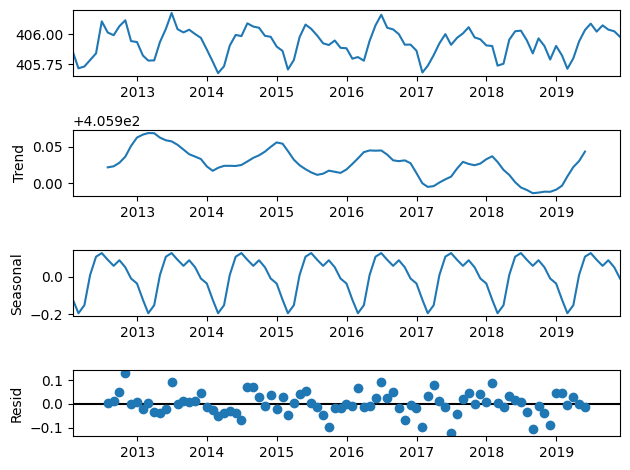

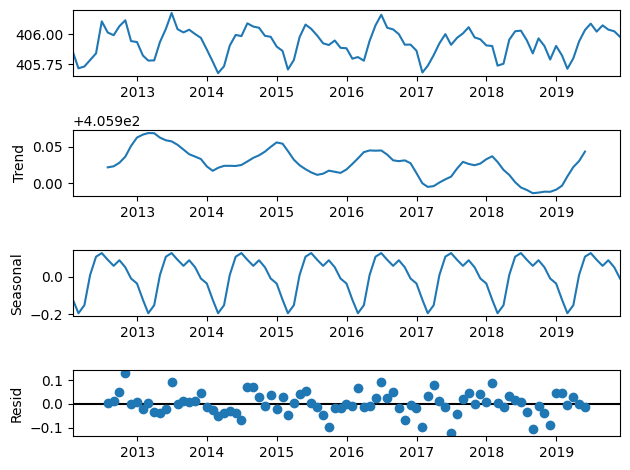

In [43]:
# decompose the monthly data to find out trends and and seasonalites 
seasonal_decompose(water_monthly).plot()

Checking for stationarity using the Partial Autocorrelation Plot

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


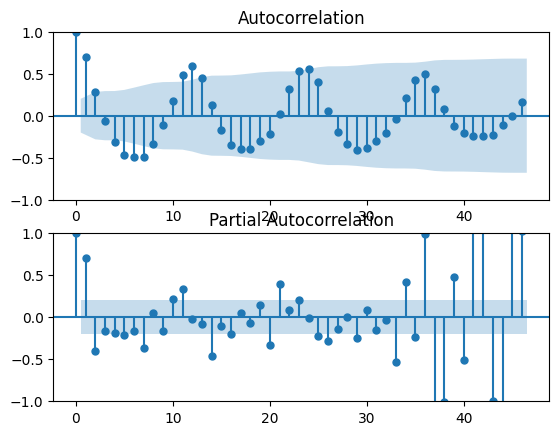

In [44]:
# plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(water_monthly, lags=46, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(water_monthly, lags=46, ax=ax[1])
plt.show()

# the first two lags of the partial autocorrelation are still significant which suggests that the time series is non-stationary 

Checking for stationarity using the ADF test

In [45]:
# check for stationarity with the ADF test using the adfuller function
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(water_monthly)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

# the p value is above 0.05, so the null hypthesis gets rejected and the water level time series is non-stationary 

ADF test statistic: -2.4233565623253295
ADF p-values: 0.13525240781777587
ADF number of lags used: 10
ADF number of observations: 84
ADF critical values: {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}
ADF best information criterion: -210.3294454437903


Differencing

<AxesSubplot: xlabel='datetime'>

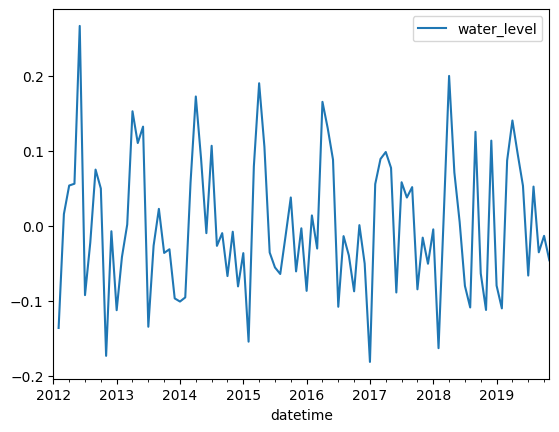

In [46]:
# differencing water level data to make it stationary 
prev_monthly_value = water_monthly.shift()
differenced_monthly = water_monthly - prev_monthly_value
differenced_monthly.plot()

check for stationarity again

In [47]:
# ADF test on differenced data, the p value is now below 0.05 and suggests that the time series is now stationary after differencing once
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced_monthly.dropna())
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -3.117132704753469
ADF p-values: 0.025310999379347113
ADF number of lags used: 12
ADF number of observations: 81
ADF critical values: {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
ADF best information criterion: -203.27107481438185


# 3. Arima Model Monthly


Train and Test split

In [48]:
# split data into training data used for training and validating the model (2012-2018) and into test data (2019) used for a final test of the models performance
train, test = train_test_split(water_monthly, train_size=84)
# split the trainings data into training (2012-2016) and validation data (2016-2018)
train_val, test_val = train_test_split(train, train_size=60)

Instantiate, train and validate model with walking forward 

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency i

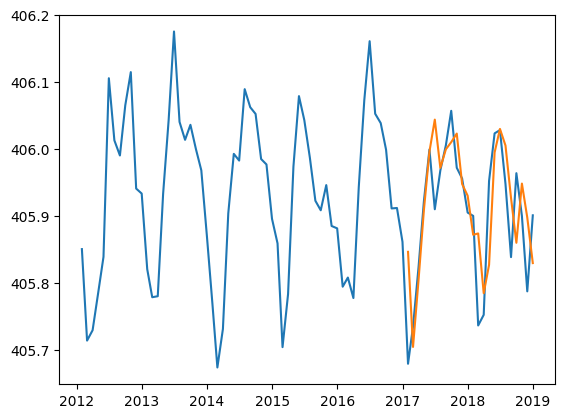

MAE: 0.05581 
MSE: 0.00547 
MAPE: 0.01375 
R2: 0.46620
None
AIC: -190.30


In [49]:
# instantiate and fit arima model manually with parameters
# optimize for model with the lowest mean errors and the highest R2
# since the monthly data was non-stationary we chose d=1 to difference the data once
# the first two lags of the PACF curve had significant autocorrelation (one positive and one negative)  which is why we set p=2 and q=2
# We also selcted our models parameters p and q by optimzing towards the lowest AIC values (we used this approach for the other models that follow in this notebook)
# We also tried to select our models with the Auto Arima function, but it turned out that we can reach lower AIC values and error measures by manually adjusting the parameters


wf_arima_preds, arima_model_m= walk_forward_validation_ARIMA(train_val, test_val, (2,1,2))

# plotting actual and predicted water level
plt.plot(train.index, train)
plt.plot(test_val.index, wf_arima_preds)
plt.show()

# print performance indicators
print(mean_errors(test_val, wf_arima_preds))
print("AIC: {:.2f}".format(arima_model_m.aic))

Final testing monthly arima model

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum

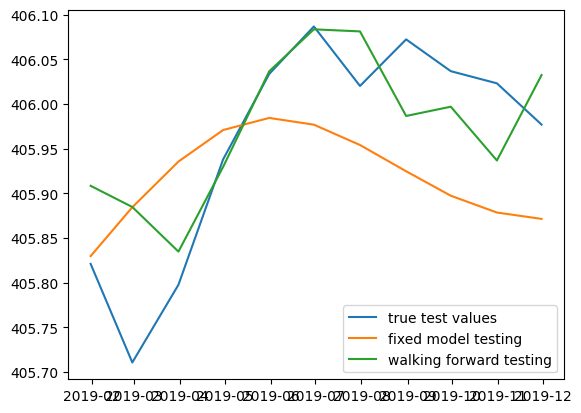

fixed parameters: 

MAE: 0.10139 
MSE: 0.01786 
MAPE: 0.02887 
R2: 0.08659
None 

walking forward: 

MAE: 0.05828 
MSE: 0.00568 
MAPE: 0.01436 
R2: 0.59905
None


In [50]:
# we are using the final testset to test the models performance for unseen data from the year 2019. This way we want to simulate how the model would perform in the real world

# we are using two approaches:
# the first one forcasts the water level for 2019 while using the walking forward approach. While we are using the model that we trained before (same parameters), we are updating 
# the data after each prediction step. This approach would simulate a model that evolves with new data and renders thus more robust results 

# on the other hand we are comparing our model´s performance if we would take the model but do not feed new data to the model after each prediction (after each month). We are 
# rather forecasting with the fixed parameters over a longer period (in this case for the year 2019). Since we are not regularly updating our data, this predictions are less
# precise as one can see by comparing the error measures and plots

# forecast using walking forward with updating data  
forecast_arima_monthly_wf, a = walk_forward_validation_ARIMA(train, test, (2,1,2))

# forecast using the fixed model without walking forward 
forecast_arima_monthly = arima_model_m.forecast(len(test))

# plotting actual and forcasted water level for 2019
plt.plot(test.index, test, label="true test values")
plt.plot(test.index, forecast_arima_monthly, label="fixed model testing")
plt.plot(test.index, forecast_arima_monthly_wf, label="walking forward testing")
plt.legend()
plt.show()

# print performance indicators
print("fixed parameters: \n")
print(mean_errors(test, forecast_arima_monthly),"\n")
print("walking forward: \n")
print(mean_errors(test, forecast_arima_monthly_wf))

# As expected the walking forward model performs better than the fixed model and is more able to predict the true variations in the water level 


# 5. SARIMA Model Monthly 

Instantiate, Fit, Train and Validate Sarima Model

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: 

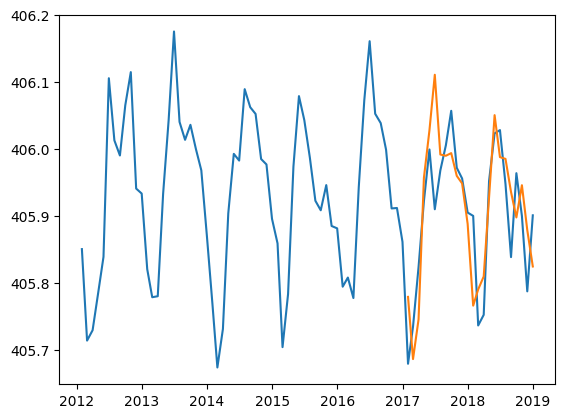

MAE: 0.05749 
MSE: 0.00518 
MAPE: 0.01416 
R2: 0.49402
None
AIC: -171.20


In [84]:
# instantiate and fit Sarima model manually with parameters
# optimize for model with the lowest mean errors and the highest R2
# here we set similar parameters like in the ARIMA model but add seasonal parameters, s=12 because we have monthly observations

wf_sarima_preds, sarima_model_m= walk_forward_validation_SARIMA(train_val, test_val, (1,1,1),(2,1,1,12))

# plotting actual and predicted water level
plt.plot(train.index, train)
plt.plot(test_val.index, wf_sarima_preds)
plt.show()

# print performance indicators
print(mean_errors(test_val, wf_sarima_preds))
print("AIC: {:.2f}".format(sarima_model_m.aic))

final testing monthly sarima

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

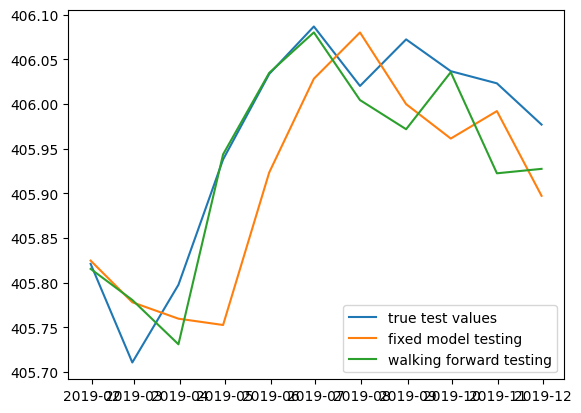

fixed parameters: 

MAE: 0.07103 
MSE: 0.02846 
MAPE: 0.03376 
R2: 0.50167
None 

walking forward: 

MAE: 0.03849 
MSE: 0.00294 
MAPE: 0.00948 
R2: 0.79231
None


In [85]:
# we are using the final testset to test the models performance for unseen data from the year 2019. This way we want to simulate how the model would perform in the real world

# we are using two approaches:
# the first one forcasts the water level for 2019 while using the walking forward approach. While we are using the model that we trained before (same parameters), we are updating 
# the data after each prediction step. This approach would simulate a model that evolves with new data and renders thus more robust results 

# on the other hand we are comparing our model´s performance if we would take the model but do not feed new data to the model after each prediction (after each month). We are 
# rather forecasting with the fixed parameters over a longer period (in this case for the year 2019). Since we are not regularly updating our data, this predictions are less
# precise as one can see by comparing the error measures and plots

# forecast with the previously selected model using walking forward with updating data  
forecast_sarima_monthly_wf, b = walk_forward_validation_SARIMA(train, test, (1,1,1),(2,1,1,12))

# forecast using the fixed model without walking forward 
forecast_sarima_monthly = sarima_model_m.forecast(len(test))

# plotting actual and forcasted water level for 2019
plt.plot(test.index, test, label="true test values")
plt.plot(test.index, forecast_sarima_monthly, label="fixed model testing")
plt.plot(test.index, forecast_sarima_monthly_wf, label="walking forward testing")
plt.legend()
plt.show()


# print performance indicators
print("fixed parameters: \n")
print(mean_errors(test, forecast_sarima_monthly),"\n")
print("walking forward: \n")
print(mean_errors(test, forecast_sarima_monthly_wf))

# As expected the walking forward model performs better than the fixed model and is more able to predict the true variations in the water level 
# In parts this model performs better than the ARIMA model, in some not

Mean Arima Residuals: 4.886813345135646
Mean Sarima Residuals: 2.438736829240284


c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


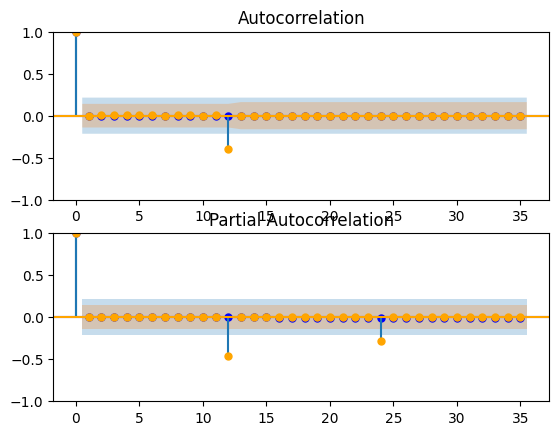

In [86]:
# plot ACF and PACF curve for residuals of SARIMA model
res_arima_m = arima_model_m.resid
res_sarima_m = sarima_model_m.resid

print("Mean Arima Residuals:", res_arima_m.mean())
print("Mean Sarima Residuals:", res_sarima_m.mean())

fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res_arima_m, lags=35, ax=ax[0], color="blue")
fig = sm.graphics.tsa.plot_pacf(res_arima_m, lags=35, ax=ax[1], color="blue")
fig = sm.graphics.tsa.plot_acf(res_sarima_m, lags=35, ax=ax[0], color= "orange", alpha=0.2)
fig = sm.graphics.tsa.plot_pacf(res_sarima_m, lags=35, ax=ax[1], color= "orange", alpha=0.2)
plt.show()

# the Arima models´ residuals show no significant correlation which means that the model captured the relevant information of the residuals
# the Sarima model (orange) captures almost all information from the residuals.
# Both Models have some bias since the mean of the residuals is not 0

# 6. Analysis of Weekly Data

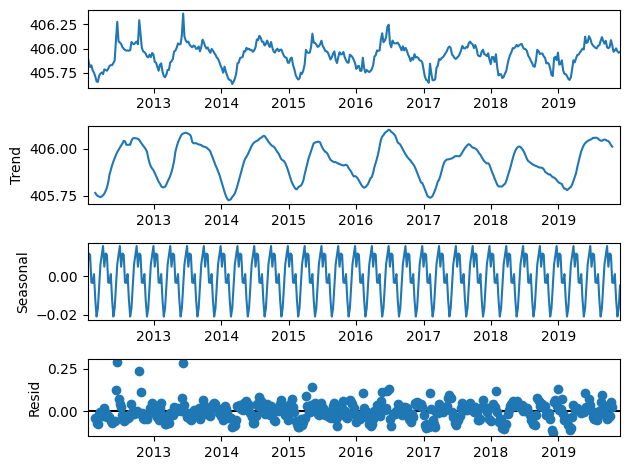

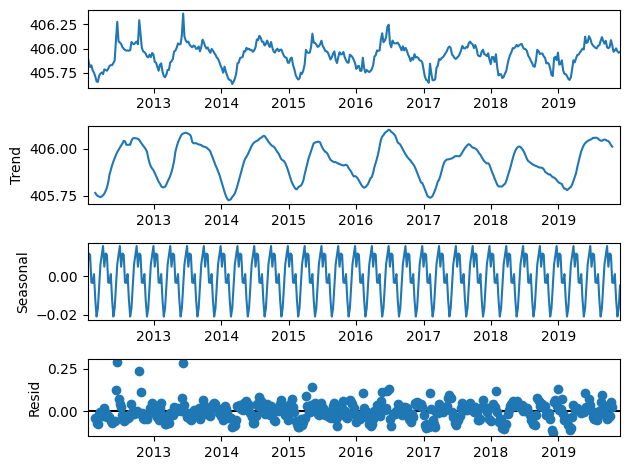

In [76]:
# decompose the monthly data to find out trends and and seasonalites 
seasonal_decompose(water_weekly,  period=13).plot()

# setting period to 13 to find quarterly seasonalities

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


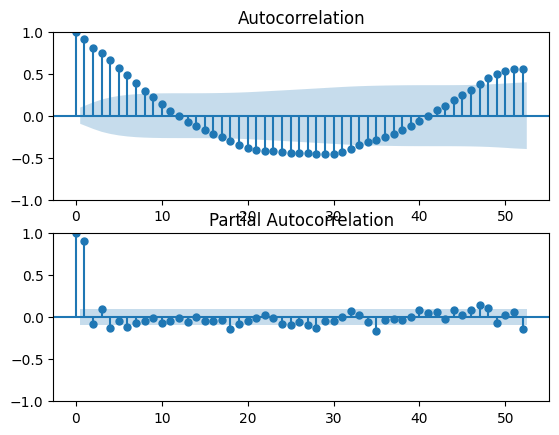

In [153]:
# plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(water_weekly, lags=52, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(water_weekly, lags=52, ax=ax[1])
plt.show()


In [77]:
# check for stationarity with the ADF test
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(water_weekly)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

# the p value is below 0.05 and the the partial autocorrleation plot shows just one significant lag which might suggest that the data is stationary

ADF test statistic: -5.09506601651987
ADF p-values: 1.4342811249084213e-05
ADF number of lags used: 5
ADF number of observations: 407
ADF critical values: {'1%': -3.4465195891135845, '5%': -2.8686676281678634, '10%': -2.5705668101226085}
ADF best information criterion: -1212.8315919588013


Train and Test splits

In [74]:
# split weekly data into a final test set containing data from 2019 and a trainings set that is used for training and validating the models 
train_we, test_we = train_test_split(water_weekly, train_size=365)
# split the weekly training data again into training data (data from 2012 - 2016) and test data used for validation (data for 2017 and 2018)
train_val_we, test_val_we = train_test_split(train_we, train_size=260)

# 7. Arima Model Weekly
instantiate, fit and validate an ARIMA model 

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No

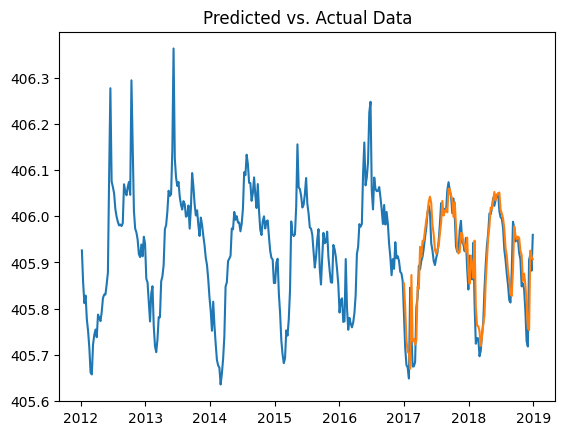

MAE: 0.03517 
MSE: 0.00231 
MAPE: 0.00867 
R2: 0.79938
None
AIC: -1132.06


In [109]:
# instantiate and fit arima model manually with parameters
# optimize for model with the lowest mean errors and the highest R2 
# since the data is stationary we set d=0 
# by optimizing for the lowest AIC we arrived at p=2 and q=1
wf_arima_preds_we, arima_model_w= walk_forward_validation_ARIMA(train_val_we, test_val_we, (2,0,3))

# plotting actual and predicted water level
plt.plot(train_we.index, train_we)
plt.plot(test_val_we.index, wf_arima_preds_we)
plt.title("Predicted vs. Actual Data")
plt.show()

# print performance indicators
print(mean_errors(test_val_we, wf_arima_preds_we))
print("AIC: {:.2f}".format(arima_model_w.aic))

Final Testing with Data from 2019

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No

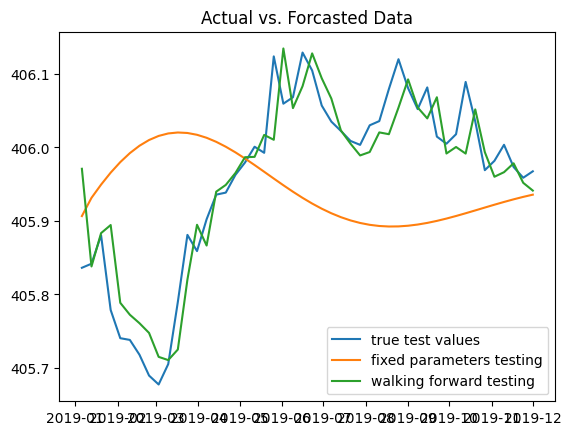

fixed parameters: 

MAE: 0.13636 
MSE: 0.01747 
MAPE: 0.02693 
R2: -0.63932
None 

walking forward: 

MAE: 0.03452 
MSE: 0.00219 
MAPE: 0.00850 
R2: 0.85776
None


In [110]:
# we are using the final testset to test the models performance for unseen data from the year 2019. This way we want to simulate how the model would perform in the real world

# we are using two approaches:
# the first one forcasts the water level for 2019 while using the walking forward approach. While we are using the model that we trained before (same parameters), we are updating 
# the data after each prediction step. This approach would simulate a model that evolves with new data and renders thus more robust results 

# on the other hand we are comparing our model´s performance if we would take the model but do not feed new data to the model after each prediction (after each week). We are 
# rather forecasting with the fixed parameters over a longer period (in this case for the year 2019). Since we are not regularly updating our data, this predictions are less
# precise as one can see by comparing the error measures and plots

# forecast with models from above using walking forward with updating data after each step (week)   
forecast_arima_weekly_wf, c = walk_forward_validation_ARIMA(train_we, test_we, (2,0,3))

# forecast using the fixed model without walking forward 
forecast_arima_weekly = arima_model_w.forecast(len(test_we))

# plotting actual and forcasted water level for 2019
plt.plot(test_we.index, test_we, label="true test values")
plt.plot(test_we.index, forecast_arima_weekly, label="fixed parameters testing")
plt.plot(test_we.index, forecast_arima_weekly_wf, label="walking forward testing")
plt.title("Actual vs. Forcasted Data")
plt.legend()
plt.show()


# print performance indicators
print("fixed parameters: \n")
print(mean_errors(test_we, forecast_arima_weekly),"\n")
print("walking forward: \n")
print(mean_errors(test_we, forecast_arima_weekly_wf))
# As expected the walking forward model performs better than the fixed model and is more able to predict the true variations in the water level. In this case the model performs
# exceptionally bad when forcasting for a long period of time


# 8. Seasonal ARIMA Model Weekly
instantiate, fit and validate SARIMA model with weekly data

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No

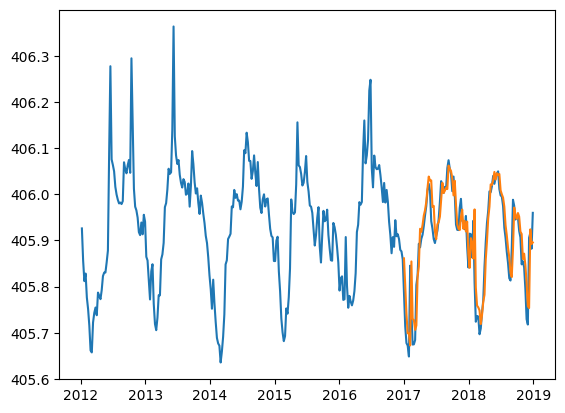

MAE: 0.03487 
MSE: 0.00233 
MAPE: 0.00859 
R2: 0.79794
None
AIC: -1128.27


In [112]:
# instantiate and fit arima model manually with parameters
# optimize for model with the lowest mean errors and the highest R2 
# we orient ourself on the parameters from the ARIMA model, s=52 because we are dealing with weekly data
wf_sarima_preds_we, sarima_model_w = walk_forward_validation_SARIMA(train_val_we, test_val_we, (2,0,3), (1,0,0,52))

# plotting actual and predicted water level
plt.plot(train_we.index, train_we)
plt.plot(test_val_we.index, wf_sarima_preds_we)
plt.show()

# print performance indicators
print(mean_errors(test_val_we, wf_sarima_preds_we))
print("AIC: {:.2f}".format(sarima_model_w.aic))

Final Testing with Data from 2019

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No

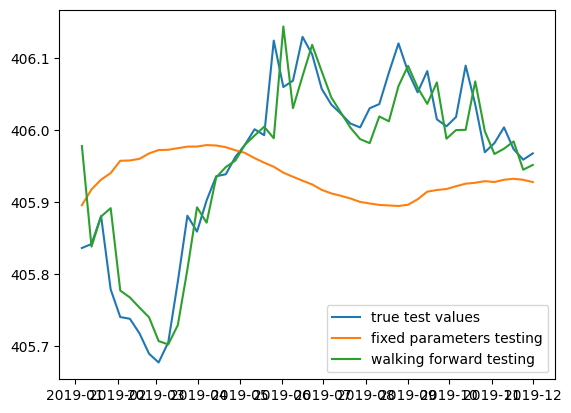

fixed parameters: 

MAE: 0.12334 
MSE: 0.01660 
MAPE: 0.02688 
R2: -0.33512
None 

walking forward: 

MAE: 0.03410 
MSE: 0.00229 
MAPE: 0.00840 
R2: 0.85125
None


In [113]:
# we are using the final testset to test the models performance for unseen data from the year 2019. This way we want to simulate how the model would perform in the real world

# we are using two approaches:
# the first one forcasts the water level for 2019 while using the walking forward approach. While we are using the model that we trained before (same parameters), we are updating 
# the data after each prediction step. This approach would simulate a model that evolves with new data and renders thus more robust results 

# on the other hand we are comparing our model´s performance if we would take the model but do not feed new data to the model after each prediction (after each week). We are 
# rather forecasting with the fixed parameters over a longer period (in this case for the year 2019). Since we are not regularly updating our data, this predictions are less
# precise as one can see by comparing the error measures and plots

# forecast with models from above using walking forward with updating data after each step (week)   
forecast_sarima_weekly_wf, d = walk_forward_validation_SARIMA(train_we, test_we, (2,0,3), (1,0,0,52))

# forecast using the fixed model without walking forward 
forecast_sarima_weekly = sarima_model_w.forecast(len(test_we))

# plotting actual and forcasted water level for 2019
plt.plot(test_we.index, test_we, label="true test values")
plt.plot(test_we.index, forecast_sarima_weekly, label="fixed parameters testing")
plt.plot(test_we.index, forecast_sarima_weekly_wf, label="walking forward testing")
plt.legend()
plt.show()


# print performance indicators
print("fixed parameters: \n")
print(mean_errors(test_we, forecast_sarima_weekly),"\n")
print("walking forward: \n")
print(mean_errors(test_we, forecast_sarima_weekly_wf))
# As expected the walking forward model performs better than the fixed model and is more able to predict the true variations in the water level.
# When fixing the parameters, the model performs very bad. It seems that a long term forecast with many intervals (i.e. weekly) is not very reliable and it might make more 
# sense to predict shorter periods and regularly update the model to get good predictions 

Mean Arima Residuals: -0.0003173892163133799
Mean Sarima Residuals: -0.0006357423478129057


c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


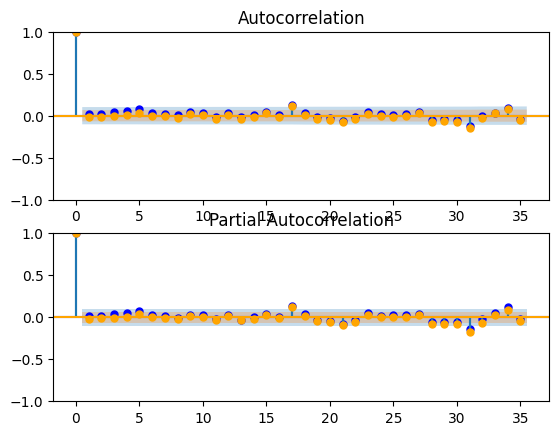

In [119]:
# plot ACF and PACF curve for residuals of SARIMA model
res_arima_w = arima_model_w.resid
res_sarima_w = sarima_model_w.resid

print("Mean Arima Residuals:", res_arima_w.mean())
print("Mean Sarima Residuals:", res_sarima_w.mean())

fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res_arima_w, lags=35, ax=ax[0], color="blue")
fig = sm.graphics.tsa.plot_pacf(res_arima_w, lags=35, ax=ax[1], color="blue")
fig = sm.graphics.tsa.plot_acf(res_sarima_w, lags=35, ax=ax[0], color= "orange", alpha=0.2)
fig = sm.graphics.tsa.plot_pacf(res_sarima_w, lags=35, ax=ax[1], color= "orange", alpha=0.2)
plt.show()

# Almost all of the residuals for both models are not significantly correlated. There are no significant spikes like in the montly data.
# It can be said that both models capture most of the information from the residuals. The mean of the residuals in are in both models close to 0 which indicates that the models
# have little bias